In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime, timedelta
from pylab import rcParams

In [2]:
### Prepare data

# load S&P500 price data since 1950:
os.chdir('/home/roman/Documents/Projects/Bubbles')
sp = pd.read_csv('^GSPC.csv', index_col = 'Date')
sp.index = pd.to_datetime(sp.index, format='%Y/%m/%d')
sp = sp['Close']
sp_norm = sp / sp[-1]

# find drawdowns (consecutive price decreases)
pmin_pmax = (sp.diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
pmax = pmin_pmax[pmin_pmax == 1]
pmin = pmin_pmax[pmin_pmax == -1]
# make sure drawdowns start with pmax, end with pmin:
if pmin.index[0] < pmax.index[0]:
    pmin = pmin.drop(pmax.index[0])
if pmin.index[-1] < pmax.index[-1]:
    pmax = pmax.drop(pmax.index[-1])
D = (np.array(sp[pmin.index]) - np.array(sp[pmax.index])) / np.array(sp[pmax.index])
d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
df = pd.DataFrame(d).set_index('Date')
df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
df = df.reindex(sp.index).fillna(0)

# calculate volatility:
window = 10
sp_vol = sp.pct_change().rolling(window).std()

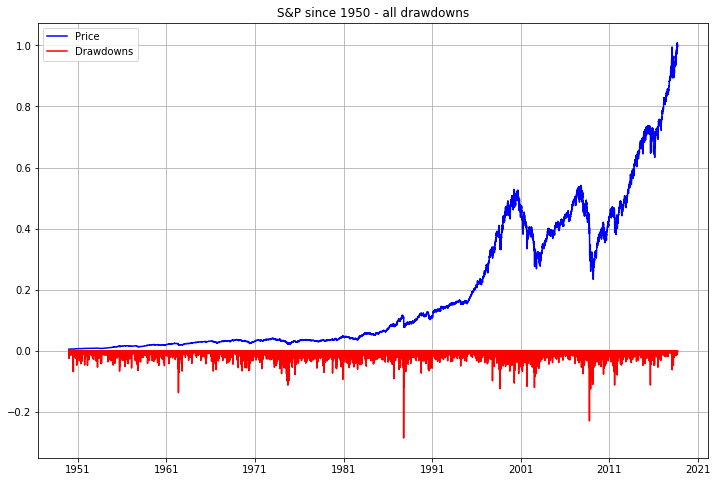

In [4]:
# Show S&P since 1951 with all drawdowns:
rcParams['figure.figsize'] = 12, 8
plt.plot(sp_norm, color='blue')
plt.plot(df['drawdown'], color='red')
plt.title('S&P since 1950 - all drawdowns')
plt.legend(['Price', 'Drawdowns'])
plt.grid()
plt.show()

In [5]:
# Identify crashes (largest drawdowns -- 99.95% quantile)
df = df.sort_values(by='drawdown')
df['rank'] = list(range(1,df.shape[0]+1))
df_bubbles = df[df['rank'] < df.quantile(q=.0005)['rank']]
print(df_bubbles)
bubble_start_dates = list(df_bubbles['d_start'])
bubble_end_dates = list(df_bubbles['d_end'])

            drawdown              d_start                d_end  rank
Date                                                                
1987-10-13 -0.285133  1987-10-13 00:00:00  1987-10-19 00:00:00     1
2008-09-30 -0.229037  2008-09-30 00:00:00  2008-10-10 00:00:00     2
1962-05-15 -0.136724  1962-05-15 00:00:00  1962-05-28 00:00:00     3
2008-11-18 -0.124174  2008-11-18 00:00:00  2008-11-20 00:00:00     4
1998-08-25 -0.124052  1998-08-25 00:00:00  1998-08-31 00:00:00     5
2002-07-17 -0.119575  2002-07-17 00:00:00  2002-07-23 00:00:00     6
1987-10-21 -0.118856  1987-10-21 00:00:00  1987-10-26 00:00:00     7
2001-09-10 -0.116005  2001-09-10 00:00:00  2001-09-21 00:00:00     8
1974-09-20 -0.112062  1974-09-20 00:00:00  1974-10-03 00:00:00     9


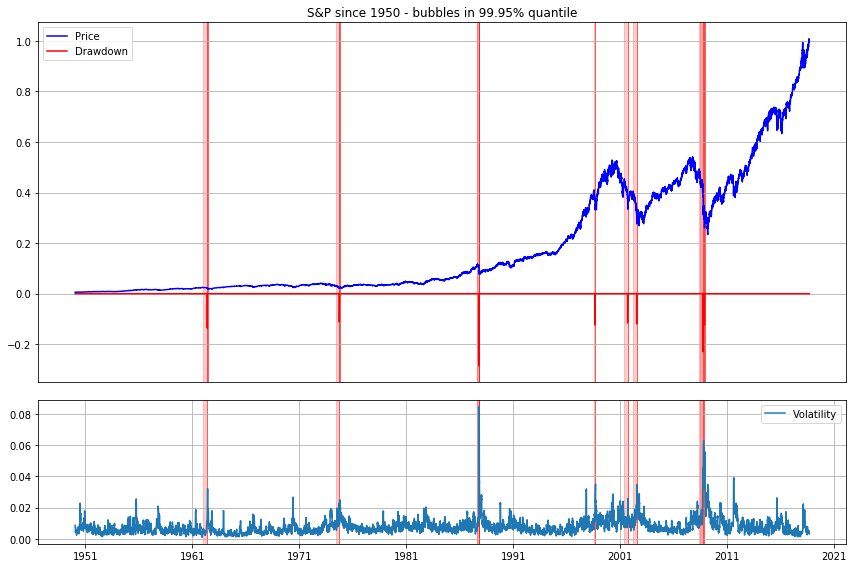

In [6]:
# plot prices, crashes, volatility since 1950
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
plt.subplot(gs[0])
df_bubbles = df_bubbles.reindex(df.index).fillna(0).sort_values(by='Date')
plt.plot(sp_norm, color='blue')
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_dates] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_dates)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_dates, bubble_end_dates)]
plt.plot(df_bubbles['drawdown'], color='red')
plt.title('S&P since 1950 - bubbles in 99.95% quantile')
plt.grid()
plt.xticks([])
plt.legend(['Price', 'Drawdown'])
plt.subplot(gs[1])
plt.plot(sp_vol)
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_dates)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_dates, bubble_end_dates)]
plt.legend(['Volatility'])
plt.grid()
plt.tight_layout()
plt.show()

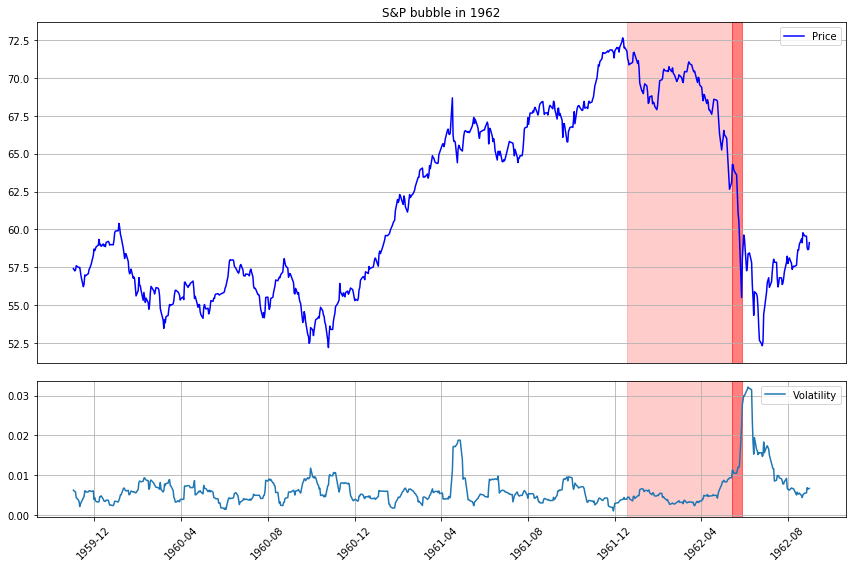

In [7]:
# 1962:
plt.subplot(gs[0])
t1 = datetime.strptime('1959-11-01', '%Y-%m-%d')
t2 = datetime.strptime('1962-08-31', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubble in 1962')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

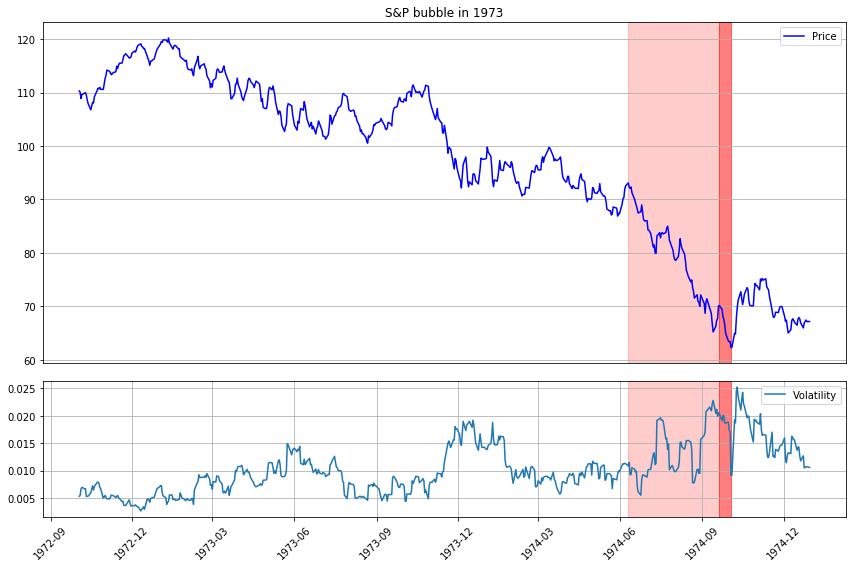

In [9]:
# 1973:
plt.subplot(gs[0])
t1 = datetime.strptime('1972-10-03', '%Y-%m-%d')
t2 = datetime.strptime('1974-12-30', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubble in 1973')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

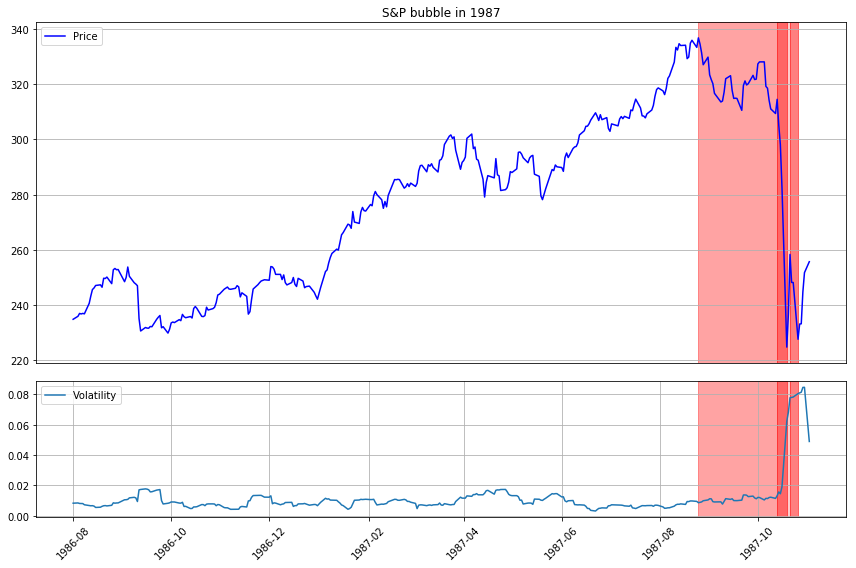

In [12]:
# 1987:
plt.subplot(gs[0])
t1 = datetime.strptime('1986-08-01', '%Y-%m-%d')
t2 = datetime.strptime('1987-11-02', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubble in 1987')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

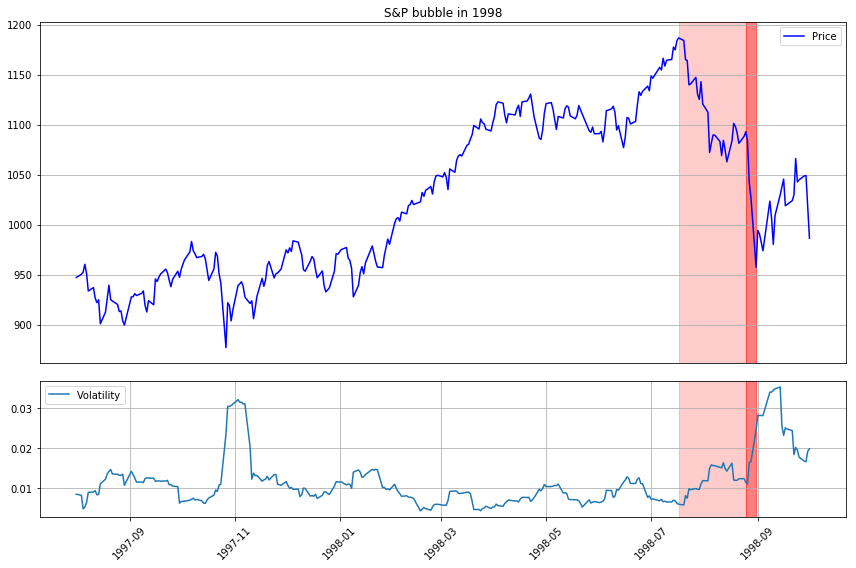

In [15]:
# 1998:
plt.subplot(gs[0])
t1 = datetime.strptime('1997-08-01', '%Y-%m-%d')
t2 = datetime.strptime('1998-10-01', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubble in 1998')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

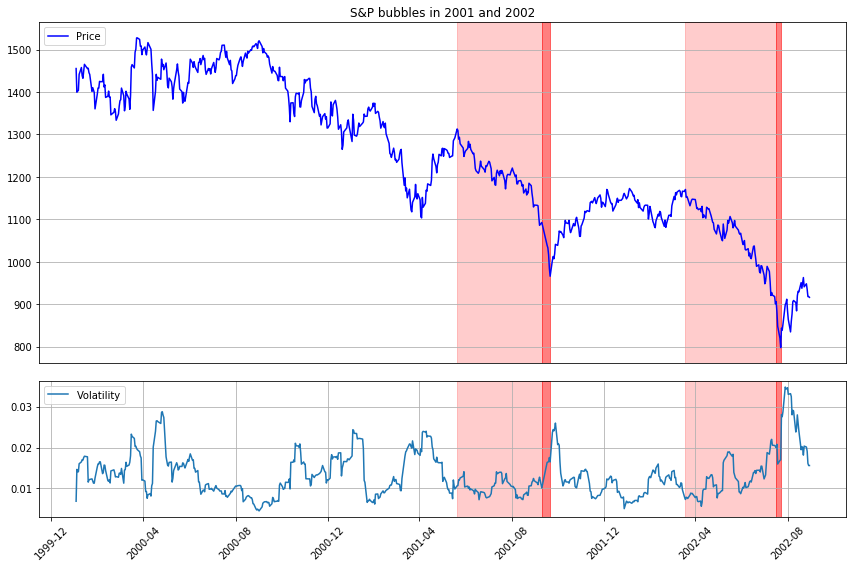

In [20]:
#2001 and 2002
plt.subplot(gs[0])
t1 = datetime.strptime('2000-01-03', '%Y-%m-%d')
t2 = datetime.strptime('2002-09-01', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubbles in 2001 and 2002')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

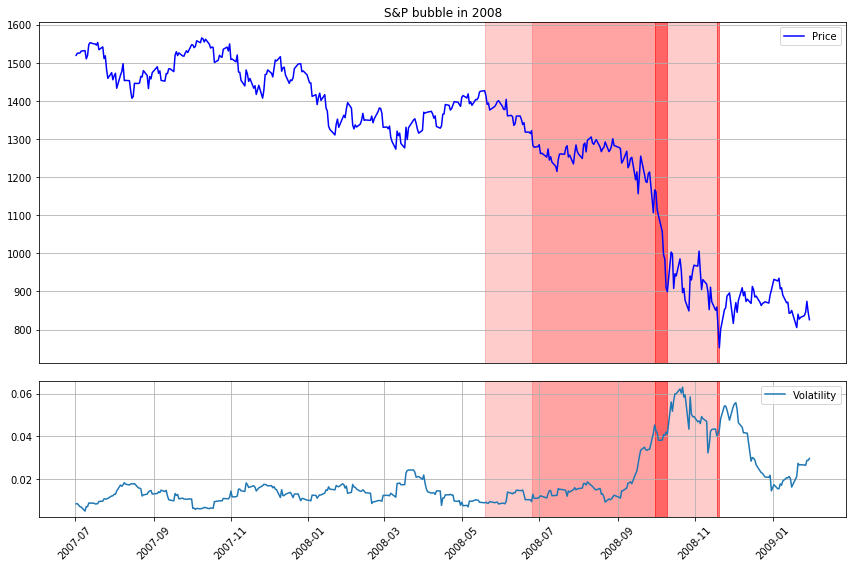

In [22]:
# 2008:
plt.subplot(gs[0])
t1 = datetime.strptime('2007-07-01', '%Y-%m-%d')
t2 = datetime.strptime('2009-02-01', '%Y-%m-%d')
bubble_start_period = list(filter(lambda x: x > t1 and x < t2, bubble_start_dates))
bubble_end_period = list(filter(lambda x: x > t1 and x < t2, bubble_end_dates))
down_start = [sp[b_s - timedelta(150):b_s].idxmax() for b_s in bubble_start_period] 
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.plot(sp.loc[t1:t2], color='blue')
plt.title('S&P bubble in 2008')
plt.xticks([])
plt.legend(['Price'])
plt.grid()
plt.subplot(gs[1])
plt.plot(sp_vol.loc[t1:t2])
[plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_start, bubble_start_period)]
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(bubble_start_period, bubble_end_period)]
plt.legend(['Volatility'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()